In [14]:
#!pip install catboost

In [158]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [159]:
df = pd.read_excel('пп_станции.xlsx')

In [160]:
df

,Станция,Номер линии,Дата,2024-04-03 00:00:00,2024-04-02 00:00:00,2024-04-01 00:00:00,2024-03-31 00:00:00,2024-03-30 00:00:00,2024-03-29 00:00:00,2024-03-28 00:00:00,...,2024-01-10 00:00:00,2024-01-09 00:00:00,2024-01-08 00:00:00,2024-01-07 00:00:00,2024-01-06 00:00:00,2024-01-05 00:00:00,2024-01-04 00:00:00,2024-01-03 00:00:00,2024-01-02 00:00:00,2024-01-01 00:00:00
0,Б.Рокоссовского,8,СОКОЛЬНИЧЕСКАЯ,16671,15113,2905,13998,12742,1217,17624,...,7280,4669,3812,5816,15740,13714,2561,11209,2722,4835
1,Черкизовская,8,СОКОЛЬНИЧЕСКАЯ,6248,5441,7991,14864,10015,9721,6623,...,13486,5061,3663,11353,6924,6496,15991,7029,3999,15638
2,Преображенск. пл,8,СОКОЛЬНИЧЕСКАЯ,14094,1132,6556,7265,4001,10961,6852,...,8176,9745,13281,15090,13309,8365,2811,5004,17068,17117
3,Сокольники СЛ,8,СОКОЛЬНИЧЕСКАЯ,18651,10083,6488,6409,9446,12051,15041,...,3637,14001,12049,15972,15545,18759,5573,15017,14176,5465
4,Красносельская,8,СОКОЛЬНИЧЕСКАЯ,7391,19339,15424,10725,5965,14682,18134,...,14194,7615,9321,16152,4581,7746,8936,11373,19561,1727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,Аэропорт Внуково,1691,СОЛНЦЕВСКАЯ ЛИН.,15787,10257,13493,8656,5761,18352,6449,...,9654,17815,12401,15277,13153,19801,17569,13950,7545,14178
318,Яхромская,18,ЛЮБЛИНСКАЯ,9813,19663,12491,9180,3563,19023,5655,...,12471,17980,2322,6341,16395,14759,14798,17189,3864,12536
319,Лианозово,18,ЛЮБЛИНСКАЯ,18978,8499,2959,12203,9070,3349,5543,...,17639,14071,17237,16304,8357,5616,16496,8603,16046,5489
320,Физтех,18,ЛЮБЛИНСКАЯ,1476,2893,9897,9793,9822,4534,4115,...,16336,17256,14147,2938,15037,3834,5997,5933,4969,5404


In [161]:
df.shape

(322, 97)

In [162]:
df = (df[df['Станция']=='Котельники'].drop(columns=['Дата','Номер линии','Станция']).T)

In [163]:
df = df.rename(columns={df.columns[0]:'stream'})

<Axes: >

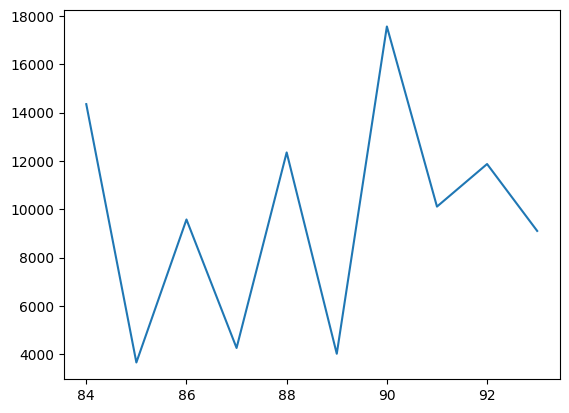

In [180]:
df.iloc[:,0][-10:].plot()

In [165]:
df['date'] = df.index

In [166]:
df.shape

(94, 2)

In [167]:
df.reset_index(drop=True,inplace=True)

In [168]:
df

,stream,date
0,9103,2024-04-03
1,11870,2024-04-02
2,10109,2024-04-01
3,17559,2024-03-31
4,4022,2024-03-30
...,...,...
89,11184,2024-01-05
90,8571,2024-01-04
91,16273,2024-01-03
92,6881,2024-01-02


In [169]:
df.stream = df.stream[::-1].reset_index(drop=True)
df.date = df.date[::-1].reset_index(drop=True)

In [170]:
df.date = df.date.apply(lambda x: x.strftime("%Y-%m-%d"))

In [171]:
df

,stream,date
0,3864,2024-01-01
1,6881,2024-01-02
2,16273,2024-01-03
3,8571,2024-01-04
4,11184,2024-01-05
...,...,...
89,4022,2024-03-30
90,17559,2024-03-31
91,10109,2024-04-01
92,11870,2024-04-02


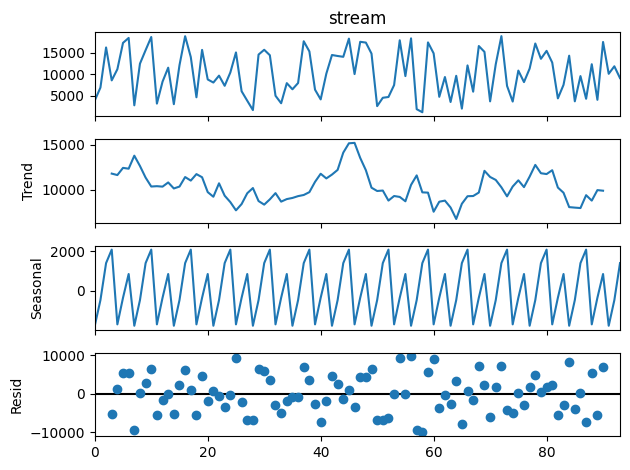

In [172]:
seasonal_decompose(df.stream, model = 'additive', period = 7).plot()
plt.show()

In [173]:
train = df[:round(df.shape[0]*0.75)]
test = df[round(df.shape[0]*0.75):]

In [174]:
marks = []

In [175]:
seasonal_periods_range = [7,30]
trend_range = ['add', 'mul', None]
seasonal_range = ['add', 'mul', None]
for p in seasonal_periods_range:
  for t in trend_range:
    for s in seasonal_range:
      fitted_model = ExponentialSmoothing(train['stream'],trend=t,seasonal=s,seasonal_periods=p).fit()
      test_predictions = fitted_model.forecast(test.shape[0]).rename('HW Test Forecast')
      print(t,s,p,mape(test.stream, test_predictions))
      marks.append(mape(test.stream, test_predictions))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


add add 7 0.6231192115853071
add mul 7 0.5886060653826016
add None 7 0.5728772918041564


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul add 7 0.6271042091335445
mul mul 7 0.5647074555685018
mul None 7 1.1390445836219747
None add 7 0.6438120925720447


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


None mul 7 0.6724526530309562
None None 7 0.571375107072693
add add 30 0.7071393659882462


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


add mul 30 0.624965685298402
add None 30 0.5728772918041564


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


mul add 30 0.7112567571001273
mul mul 30 0.5728076031206938
mul None 30 1.1390445836219747
None add 30 0.7307718529788655
None mul 30 0.75461312185642
None None 30 0.571375107072693


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [176]:
test.date

70    2024-03-11
71    2024-03-12
72    2024-03-13
73    2024-03-14
74    2024-03-15
75    2024-03-16
76    2024-03-17
77    2024-03-18
78    2024-03-19
79    2024-03-20
80    2024-03-21
81    2024-03-22
82    2024-03-23
83    2024-03-24
84    2024-03-25
85    2024-03-26
86    2024-03-27
87    2024-03-28
88    2024-03-29
89    2024-03-30
90    2024-03-31
91    2024-04-01
92    2024-04-02
93    2024-04-03
Name: date, dtype: object

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-177-f220a2c8efd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1.loc[len(train)] = [test.stream[len(train)], str((datetime.strptime(train.iloc[len(train)-1].date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d"))]


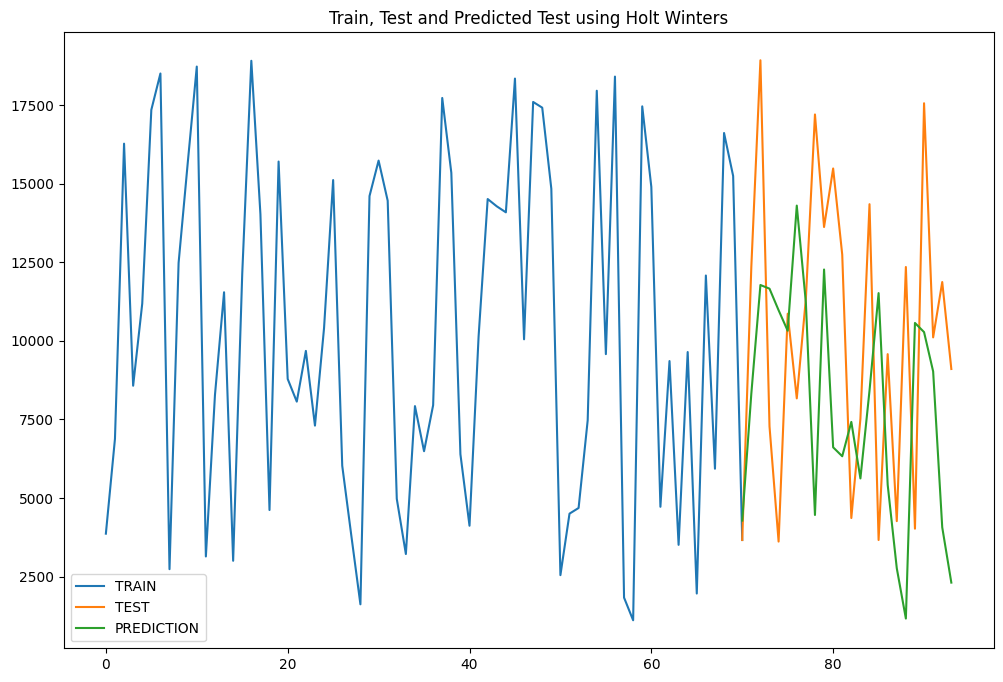

In [177]:
fitted_model = ExponentialSmoothing(train['stream'],trend='add',seasonal='mul',seasonal_periods=30).fit()
test_predictions = fitted_model.forecast(test.shape[0]).rename('stream')
train1 = train
train1.loc[len(train)] = [test.stream[len(train)], str((datetime.strptime(train.iloc[len(train)-1].date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d"))]
train1['stream'].plot(legend=True,label='TRAIN')
test['stream'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters');

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-178-06392011fc1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1.loc[len(train)] = [test.stream[len(train)], str((datetime.strptime(train.iloc[len(train)-1].date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d"))]


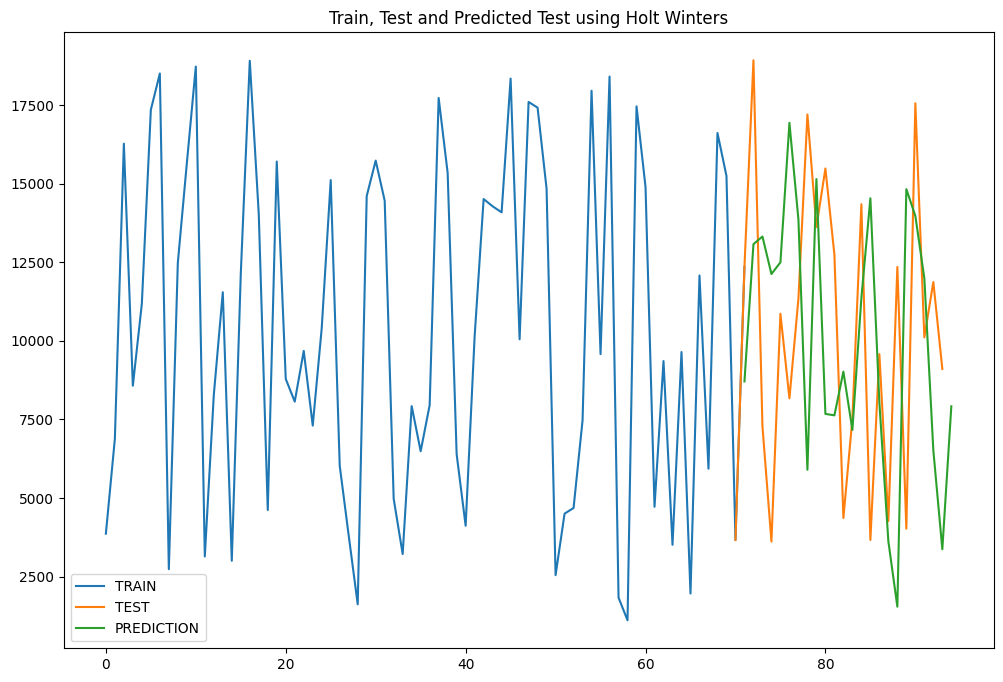

In [178]:
fitted_model = ExponentialSmoothing(train['stream'],trend='mul',seasonal='add',seasonal_periods=30).fit()
test_predictions = fitted_model.forecast(test.shape[0]).rename('stream')
train1 = train
train1.loc[len(train)] = [test.stream[len(train)], str((datetime.strptime(train.iloc[len(train)-1].date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d"))]
train1['stream'].plot(legend=True,label='TRAIN')
test['stream'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters');

In [157]:
train

,stream,date
0,15793,2024-01-01
1,18594,2024-01-02
2,9664,2024-01-03
3,14998,2024-01-04
4,16294,2024-01-05
...,...,...
67,12370,2024-03-08
68,6116,2024-03-09
69,17511,2024-03-10
70,4789,2024-03-11


CATBOOST

In [112]:
def clear_df(df):
    df = df.rename(columns=lambda x: x.lower())
    date_range = pd.date_range(start=df.date[0], end=df.date[df.date.size-1], freq='D')
    df_full_dates = pd.DataFrame(date_range, columns=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df = pd.merge(df_full_dates, df, how='left', on='date')
    return df

In [113]:
def make_df(df:pd.DataFrame, lookback:int = 7):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df.date.apply(lambda x: x.year)
    df['month'] = df.date.apply(lambda x: x.month)
    df['day'] = df.date.apply(lambda x: x.day)
    print(df)
    df = df.drop(columns = ['date'])
    for i in range(1,lookback+1):
        df['shift'+str(i)] = df.stream.shift(i)
    df = df[lookback:]
    return df.reset_index(drop=True)

In [360]:
df_cb = make_df(df,7)

    stream       date  year  month  day
0    19070 2024-01-01  2024      1    1
1    15875 2024-01-02  2024      1    2
2    10479 2024-01-03  2024      1    3
3    14529 2024-01-04  2024      1    4
4     8865 2024-01-05  2024      1    5
..     ...        ...   ...    ...  ...
89    4768 2024-03-30  2024      3   30
90    2041 2024-03-31  2024      3   31
91    8663 2024-04-01  2024      4    1
92   17088 2024-04-02  2024      4    2
93   12370 2024-04-03  2024      4    3

[94 rows x 5 columns]


In [361]:
cb = CatBoostRegressor()

In [362]:
y = df_cb['stream']
X = df_cb.drop(columns=['stream'])

In [363]:
r = 0.75
ind = round(r*len(X))
X_train = X[:ind]
X_test = X[ind:]
y_train = y[:ind]
y_test = y[ind:]

In [364]:
cb.fit(X_train,y_train)

Learning rate set to 0.026584
0:	learn: 5988.4379576	total: 3.45ms	remaining: 3.45s
1:	learn: 5952.7060590	total: 4.45ms	remaining: 2.22s
2:	learn: 5923.5400180	total: 5.34ms	remaining: 1.77s
3:	learn: 5872.4179249	total: 6.2ms	remaining: 1.54s
4:	learn: 5844.8525855	total: 7.05ms	remaining: 1.4s
5:	learn: 5813.2485472	total: 7.89ms	remaining: 1.31s
6:	learn: 5785.6114976	total: 8.71ms	remaining: 1.24s
7:	learn: 5747.7122375	total: 9.53ms	remaining: 1.18s
8:	learn: 5707.6919580	total: 10.4ms	remaining: 1.14s
9:	learn: 5663.1037340	total: 11.2ms	remaining: 1.11s
10:	learn: 5624.1298458	total: 12.2ms	remaining: 1.09s
11:	learn: 5582.9109841	total: 13ms	remaining: 1.07s
12:	learn: 5536.6561504	total: 13.8ms	remaining: 1.05s
13:	learn: 5504.8983792	total: 14.7ms	remaining: 1.03s
14:	learn: 5475.3394599	total: 15.5ms	remaining: 1.02s
15:	learn: 5455.2855902	total: 16.3ms	remaining: 1s
16:	learn: 5436.9912428	total: 17.1ms	remaining: 991ms
17:	learn: 5401.0933721	total: 18ms	remaining: 981ms

In [365]:
preds = cb.predict(X_test)

In [366]:
mape(y_test,preds)

0.6646500559797219

In [367]:
preds = pd.Series(preds)
preds.index = y_test.index

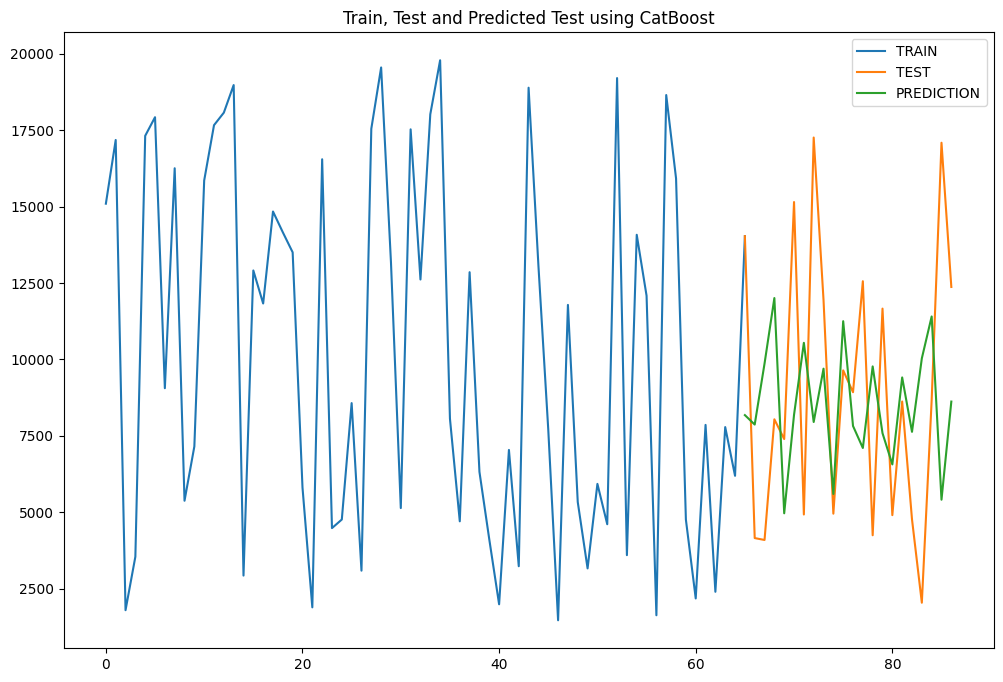

In [368]:
y_train.loc[len(y_train)] = y_test[len(y_train)]
y_train.plot(legend=True,label='TRAIN')
y_test.plot(legend=True,label='TEST',figsize=(12,8))
preds.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using CatBoost');